In [1]:
#容器持久化python lib地址，因为使用的镜像是conda管理环境，目前没找到方法添加第三方lib路径到conda环境中
#安装命令
#pip install --install-option="--prefix=/jupyter-datascience-notebook/packages" --ignore-installed <your-package>
import sys
sys.path.append('/jupyter-datascience-notebook/packages/lib/python3.6/site-packages')

# GIT地址  https://github.com/jussker/OCR_example

In [2]:
# import numpy
# import scipy
# import matplotlib
# import PIL
# import OpenGL
# import pydot
# import simplejson
# import sqlite3
# import cherrypy

In [3]:
from PIL import Image
from scipy.ndimage import filters
from numpy import ndarray,array,zeros,argsort,sort
import matplotlib.pyplot as pyplot
import logging
import sys

# Get root logger (all other loggers will be derived from this logger's
# properties)
logger = logging.getLogger()


In [4]:
def compute_harris_response(im, sigma=3):
    """ 在一幅灰度图像中，对每个像素计算 Harris 角点检测器响应函数"""
    # 计算导数
    imx = zeros(im.shape)
    filters.gaussian_filter(im, (sigma, sigma), (0, 1), imx)
    imy = zeros(im.shape)
    filters.gaussian_filter(im, (sigma, sigma), (1, 0), imy)
    
    # 计算Harris 矩阵的分量
    Wxx = filters.gaussian_filter(imx * imx, sigma)
    Wxy = filters.gaussian_filter(imx * imy, sigma)
    Wyy = filters.gaussian_filter(imy * imy, sigma)
    
    # 计算特征值和迹
    Wdet = Wxx * Wyy - Wxy * 2
    Wtr = Wxx + Wyy
    
    return Wdet / Wtr

In [5]:
def get_harris_points(harrisim, min_dist=10, threshold=0.1):
    """ 从 一幅 Harris 响应 图像 中 返回 角 点。 min_ dist 为 分割 角 点 和 图像 边界 的 最少 像素 数目"""
    # 寻找高于阈值的候选角点
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1
    
    # 得到候选点的坐标
    coords = array(harrisim_t.nonzero()).T
    
    # 以及它们的Harris响应值
    candidate_values = [harrisim[c[0], c[1]] for c in coords]
    
    # 对候选点按照Harris响应值进行排序
    index = argsort(candidate_values)
    
    # 将可行点的位置保存到数组中
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1
    
    # 按照min_distance 原则,选择最佳Harris点
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i,0],coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i, 0] - min_dist):(coords[i, 0] + min_dist),
                              (coords[i, 1] - min_dist):(coords[i, 1] + min_dist)
                             ] = 0
    return filtered_coords 
    

In [6]:
def plot_harris_points(image, filtered_coords):
    """绘制图像中检测到的角点"""
    pyplot.figure(figsize=(50,50))
    pyplot.gray()
    pyplot.imshow(image)
    pyplot.plot([p[1] for p in filtered_coords], [p[0] for p in filtered_coords], '*')
    pyplot.axis('off')
    pyplot.show()
    

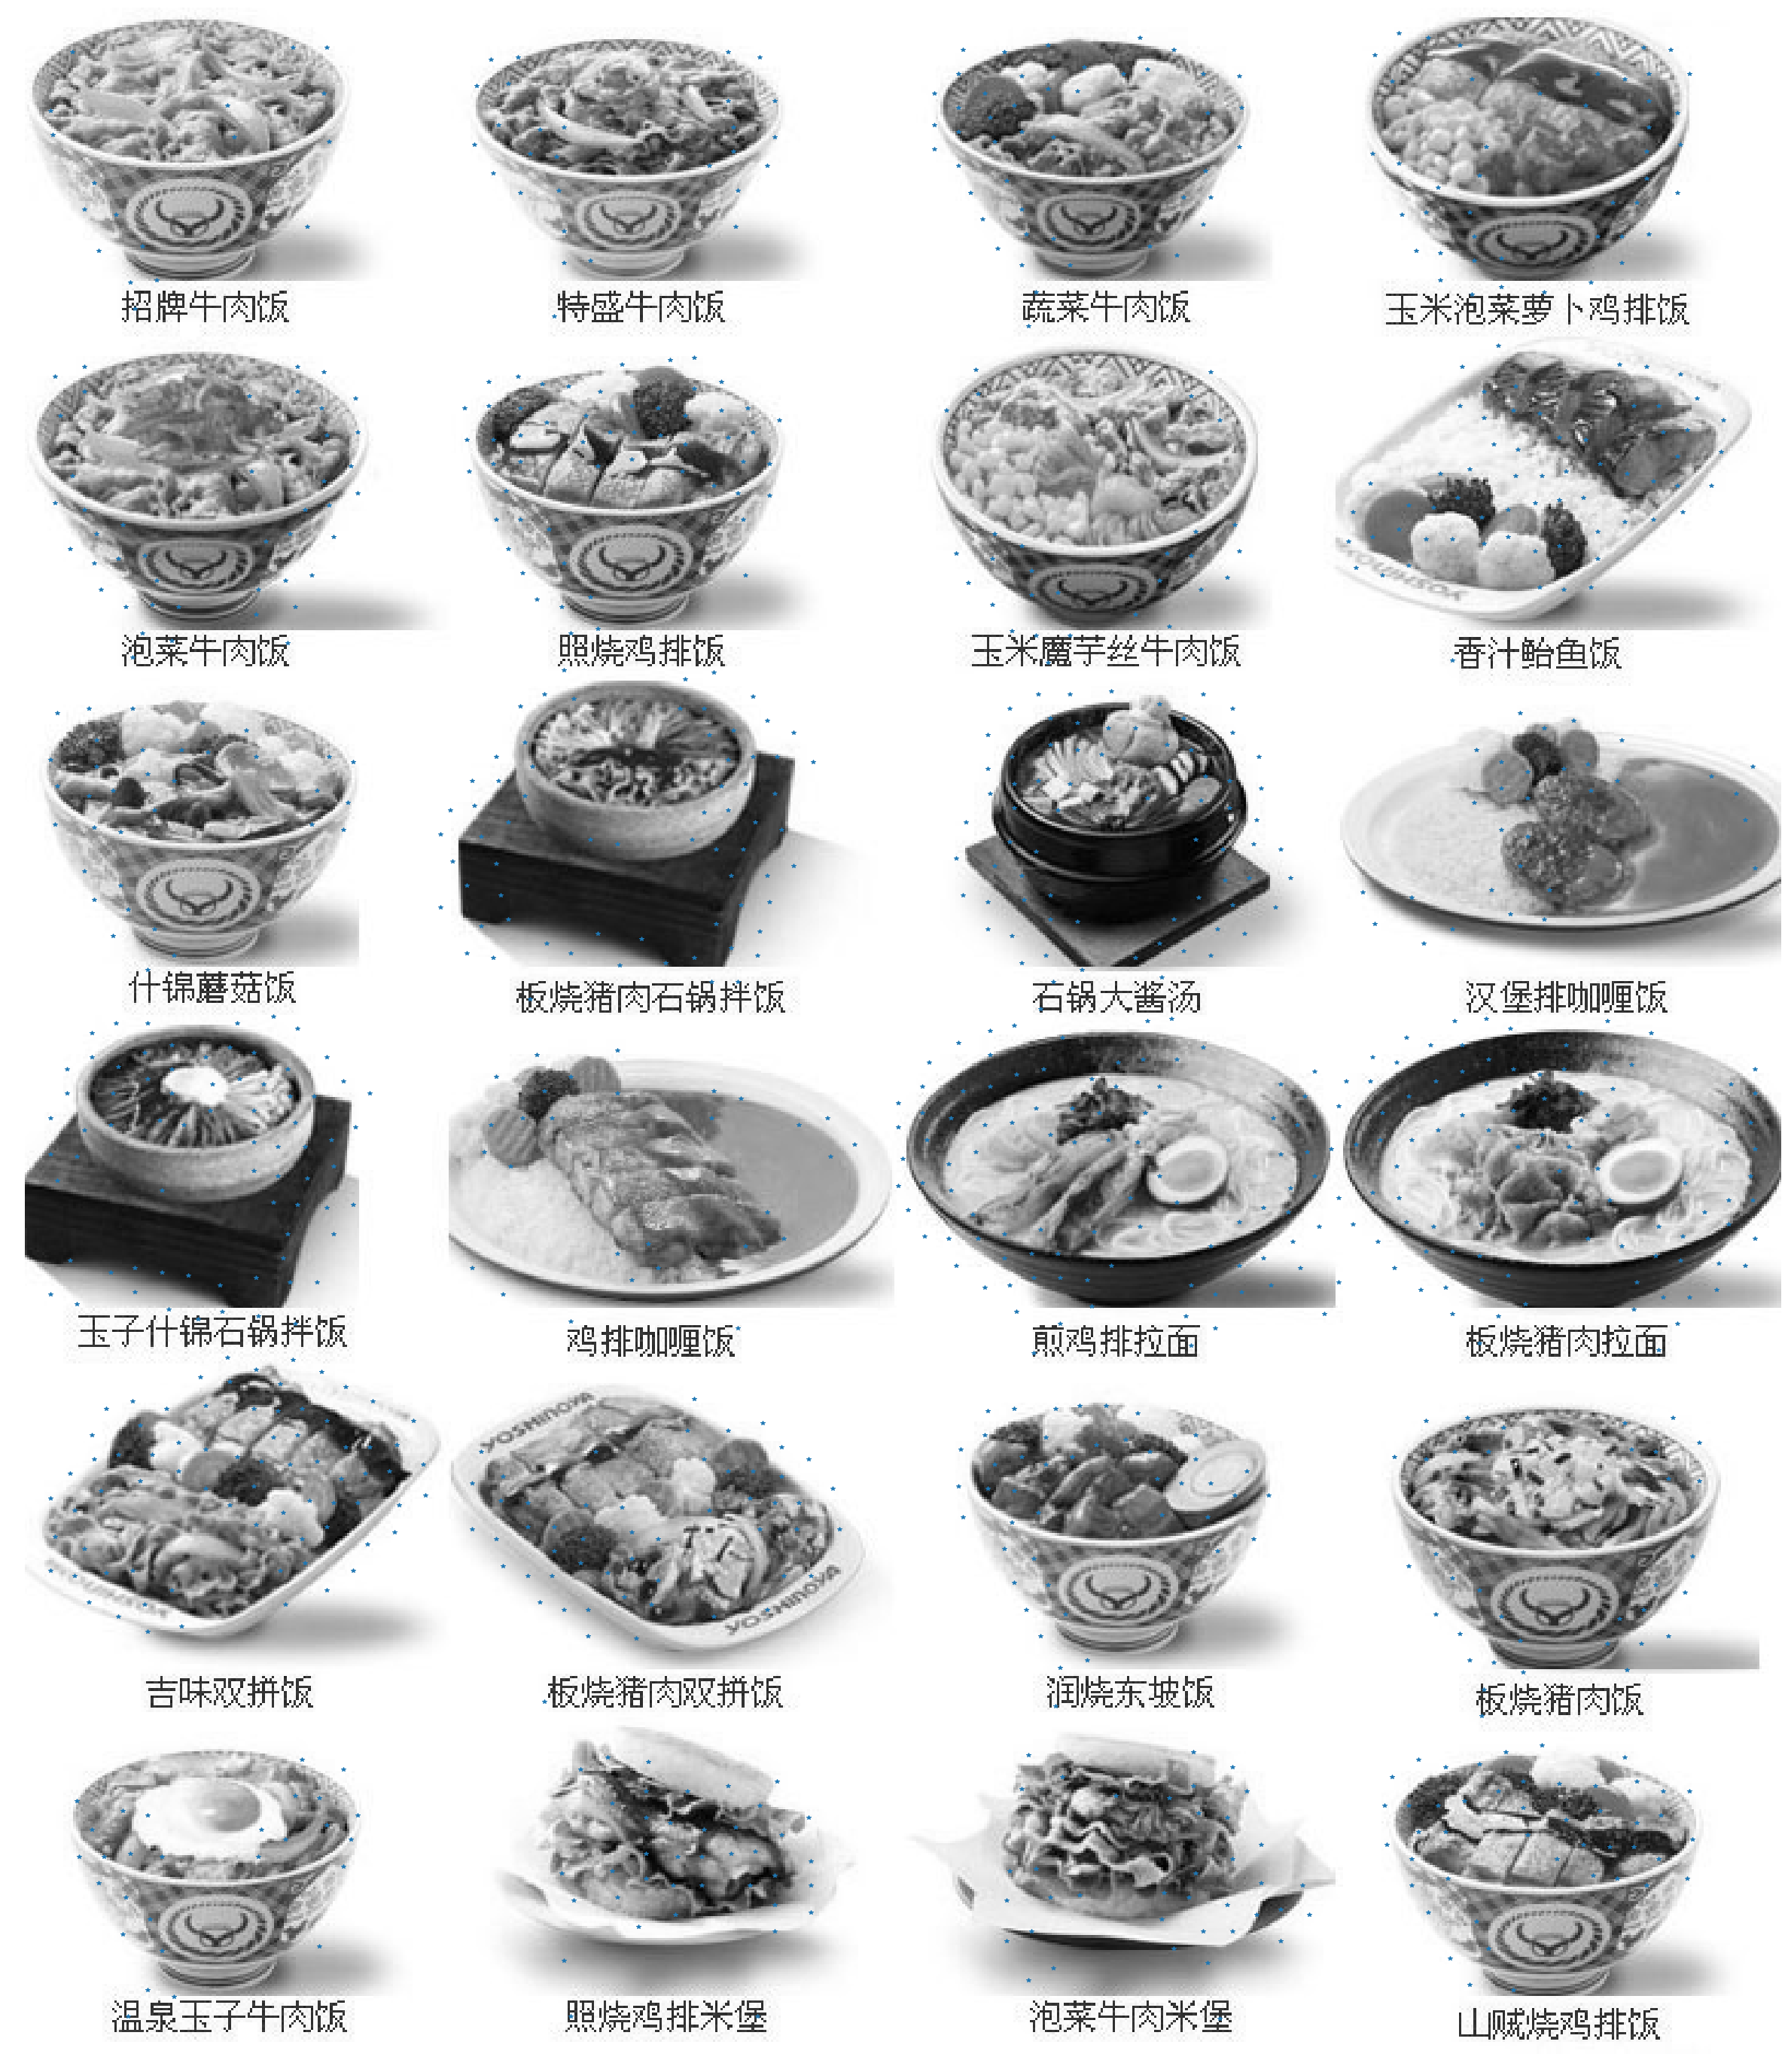

In [10]:
im = array(Image.open('./../resources/2018-03-06/2.jpg').convert('L'))
harrisim = compute_harris_response(im,5)
filtered_coords = get_harris_points(harrisim, min_dist=10, threshold=0.1)
plot_harris_points(im, filtered_coords)